In [6]:
import os
import yaml
import re 

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import PillowWriter
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib import patches


import healpy as hp
from reproject import reproject_from_healpix
import json

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.wcs import utils as asutils
from astropy.visualization.wcsaxes.frame import EllipticalFrame

from scipy.optimize import curve_fit
from skimage.filters import difference_of_gaussians, window, gaussian
from skimage.io import imread, imshow
from skimage.feature import peak_local_max
from skimage import color, exposure, transform
from skimage.feature import blob_dog, blob_log, blob_doh

from scipy.ndimage import gaussian_filter

from helpers import *
%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
milagrotextcolor, milagro = setupMilagroColormap(-3, 15, 2, 256)
milagrotextcolor2, milagro2 = setupMilagroColormap(0.2, 1, 2, 256)

ROI center 18, 0
Coords= [18, 0, 5, 4]
18 0 1800 1440
B
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-AIT' 'GLAT-AIT' 
CRVAL : 18.0 0.0 
CRPIX : 900.0 720.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00555555555555555 0.005555555555555556 
NAXIS : 1800  1440
Fits File loaded
Degrees per pixel: 0.005555555555555556 
Shape of Map in pixel number: 1800 X 1440


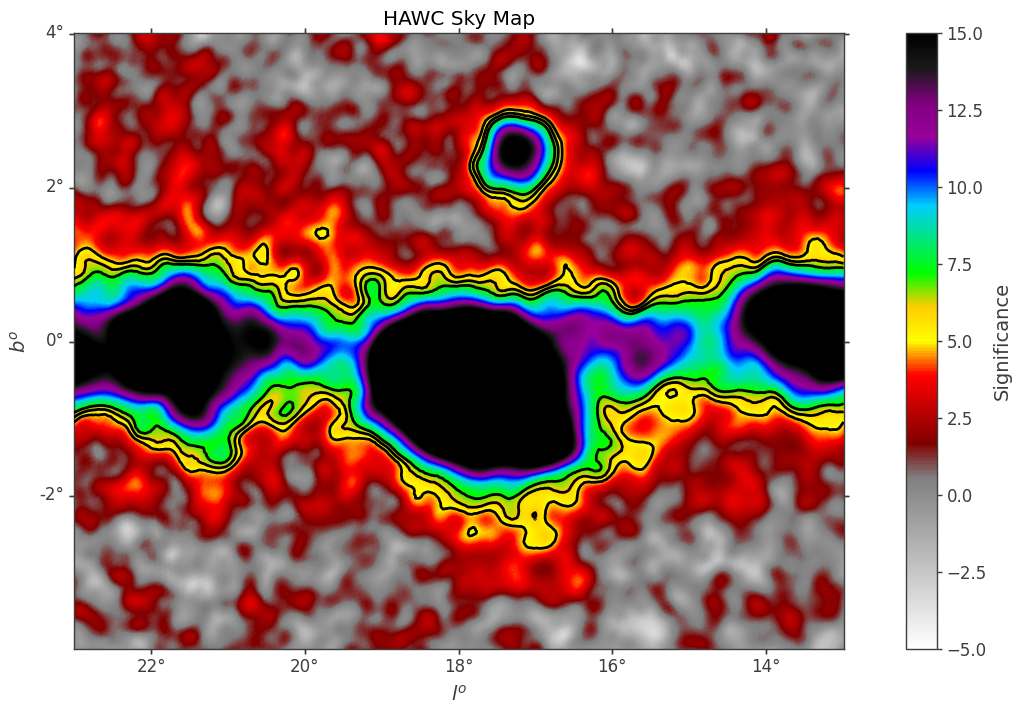

In [8]:
# Load the Simulation FITS file
%matplotlib inline
filename = '/Users/rishi/Documents/Analysis/data/aligned-ml-wholesky-neg-ext0.0.fits.gz'

ra_center = 18
dec_center = 0

print(f"ROI center {ra_center}, {dec_center}")

coord_sys = 'G'
xlength=5
ylength=4

origin = [ra_center, dec_center, xlength, ylength] 
ra_center = "{:.2f}".format(ra_center)
dec_center = "{:.2f}".format(dec_center)

array, footprint, wcs = loadmap(filename, coord_sys, origin, 'origin')
xnum = array.shape[1]
ynum = array.shape[0]

pixel_size = wcs.wcs.cdelt[1]
print(f'Degrees per pixel: {pixel_size} ')

print(f'Shape of Map in pixel number: {xnum} X {ynum}')
fig = plt.figure(figsize=(20,8))
ax = plt.subplot(1,1,1, projection=wcs)
im=ax.imshow(array,  cmap=milagro, vmin=-5, vmax=15)
fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04, label='Significance')
levels = [5, 6, 7]
hi_transform = ax.get_transform(wcs)
ax.contour(array, levels=levels, transform=hi_transform, colors='black')
plot_ax_label(ax, coord_sys)
# plot_4hwc1D(ax, wcs)
ax.set_title('HAWC Sky Map')
plt.xlim(0, xnum)
plt.ylim(0, ynum)
plt.show()

In [9]:
# Stop if there are no hotspots greater than 5 sigma
if np.max(array) < 5:
    print(f'Algorithm wont proceed. Significance Map has no data greater than 4$\sigma$)')
    fig, ax = plt.subplots(figsize=(8.5, 11))  # Create a blank canvas (8.5x11 inches for letter size)
    ax.axis('off')  # Turn off axes
    text = f"Algorithm wont proceed. Significance Map has no data greater than 4$\sigma$)"
    ax.text(0.5, 0.5, text, fontsize=12, ha='center', va='center', wrap=True)
    plt.show()
    exit

In [10]:
# Preprocessing Step: Floor the image for analysis
print(np.min(array))
print(np.max(array))
if np.min(array) < -5:
    print("Image Floored to -5 sigma")
    array = invrelu(array, floor_min=-5)

-3.9045264226284293
93.16927684607245


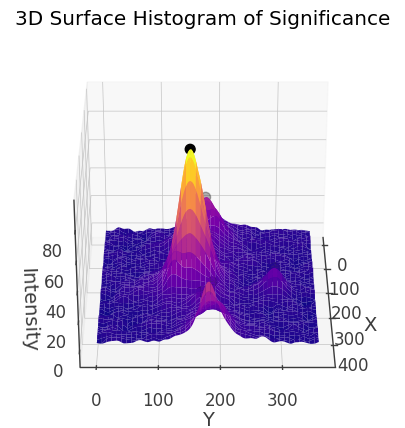

In [11]:
# Make the 3D Intensity Distribution
smoothed = array
smoothed = smoothed[::4, ::4]
x = np.arange(smoothed.shape[1])
y = np.arange(smoothed.shape[0])
X, Y = np.meshgrid(x, y)

coordinates = peak_local_max(smoothed, min_distance=5, threshold_rel=0.1)
peak_x = coordinates[:, 1]
peak_y = coordinates[:, 0]
peak_z = smoothed[peak_y, peak_x]


fig = plt.figure(figsize=(6, 5))#, dpi=80)
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, smoothed, cmap='plasma', edgecolor='none')
peaks_plot = ax.scatter(peak_x, peak_y, peak_z, c='black', s=50, label='Peaks')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Intensity')
ax.set_title('3D Surface Histogram of Significance')
def update(frame):
    ax.view_init(elev=30, azim=frame)
    return fig,

ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
ani.save(f'gaussian_surface_rotation-{1825}.gif', writer='pillow')

In [12]:
#Make Stacked Significane Range Plots

x = np.linspace(3, np.max(array)+3, 15)
print(x)
fig = plt.figure(figsize=(20,8))
ax = plt.subplot(1, 1, 1, projection=wcs)
im = ax.imshow(array, cmap=milagro, vmin=x[0], vmax=x[1])
cbar = fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04, label='Significance')
plot_ax_label(ax, coord_sys)
ax.set_title(f'HAWC Sky Map from {x[0]} to {x[1]}')
ax.set_xlim(0, xnum)
ax.set_ylim(0, ynum)

def update(i):
    if i < len(x) - 1:
        im.set_clim(vmin=x[i], vmax=x[i+1])
        ax.set_title(f'HAWC Sky Map from {x[i]} to {x[i+1]}')
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(x)-1, interval=1000, blit=False)
ani.save(f'hawc_sky_map-{1825}.gif', writer=PillowWriter(fps=1))
plt.clf()

[ 3.          9.65494835 16.30989669 22.96484504 29.61979338 36.27474173
 42.92969008 49.58463842 56.23958677 62.89453512 69.54948346 76.20443181
 82.85938015 89.5143285  96.16927685]


<Figure size 2000x800 with 0 Axes>

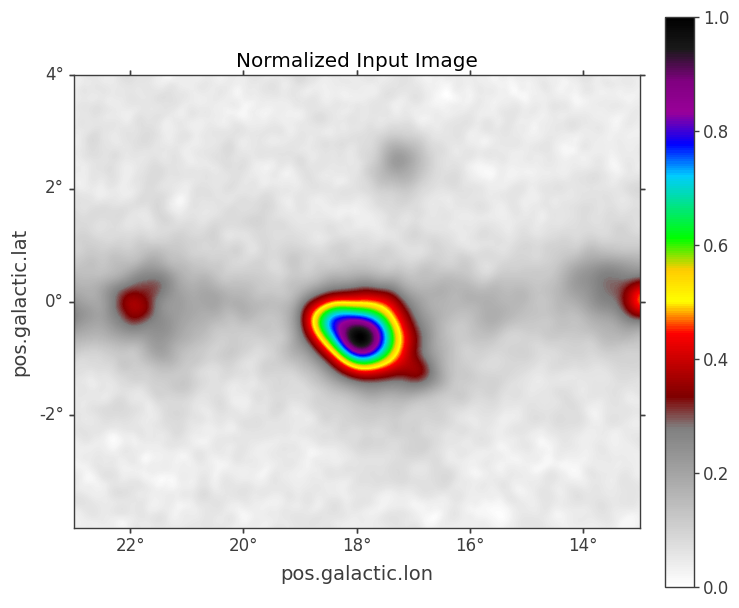

In [13]:
#Normalize the image between 0 and 1 for analysis

image = array
image = (image-np.min(image))/(np.max(image)-np.min(image))
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1, projection=wcs)

im=ax.imshow(image,  cmap=milagro)
fig.colorbar(im, orientation='vertical' ,fraction=0.046, pad=0.04)
ax.set_title("Normalized Input Image")
ax.set_xlim(0, xnum)
ax.set_ylim(0, ynum)
plt.show()
plt.close(fig)

Length of bins=2592


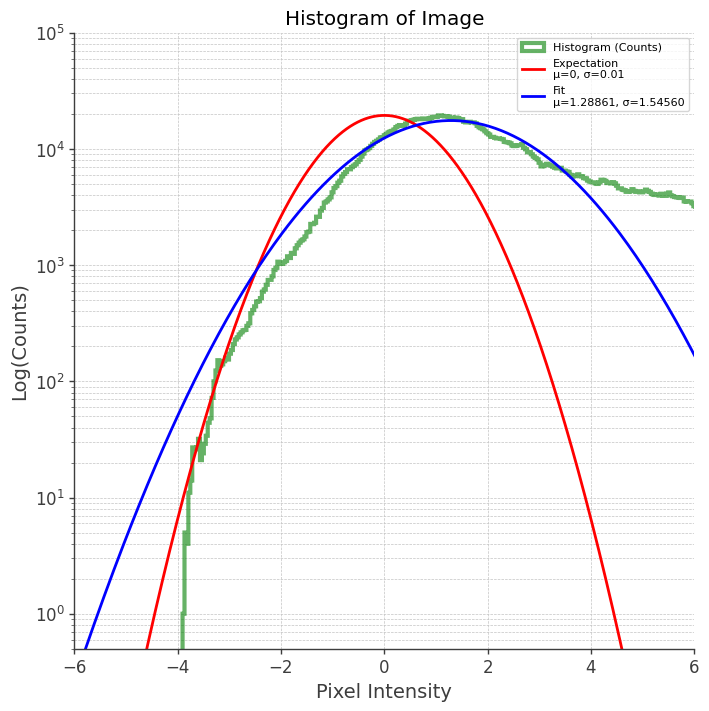

In [14]:
# Calculate the 1D histogram of the image
pixels = array.flatten()
binlen = int(len(pixels)/1000)
print(f"Length of bins={binlen}")
counts, bin_edges = np.histogram(pixels, bins=binlen, range=(-4, np.max(pixels)))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 

def gaussian_fit(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean)**2) / (2 * stddev**2))

x_exp = np.linspace(-5, 5, binlen)
y_exp = gaussian_fit(x_exp, counts.max(), 0, 1)

initial_guess = [counts.max(), bin_centers[np.argmax(counts)], np.std(pixels)]
popt, _ = curve_fit(gaussian_fit, bin_centers, counts, p0=initial_guess)
# x_fit = np.linspace(bin_centers[0]-2, bin_centers[-1], 500)
x_fit = np.linspace(-6, np.max(pixels), binlen)
y_fit = gaussian_fit(x_fit, *popt)

plt.figure(figsize=(8, 8))

log_counts = np.where(counts > 0, counts, 1) 
plt.hist(pixels, bins=binlen, range=(np.min(pixels), np.max(pixels)), color='fuchsia', edgecolor='green', alpha=0.6, label='Histogram (Counts)', histtype='step', linewidth=3)
plt.plot(x_exp, y_exp, 'red', linewidth=2, label=f'Expectation\nμ=0, σ=0.01')
plt.plot(x_fit, y_fit, 'blue', linewidth=2, label=f'Fit\nμ={popt[1]:.5f}, σ={popt[2]:.5f}')
plt.yscale('log')
plt.ylim(0.5, 1e5)
plt.xlim(-6, 6)
plt.xlabel('Pixel Intensity')
plt.ylabel('Log(Counts)')
plt.title('Histogram of Image')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
plt.close(fig)

0.025518842970585293
0.8658757491291675


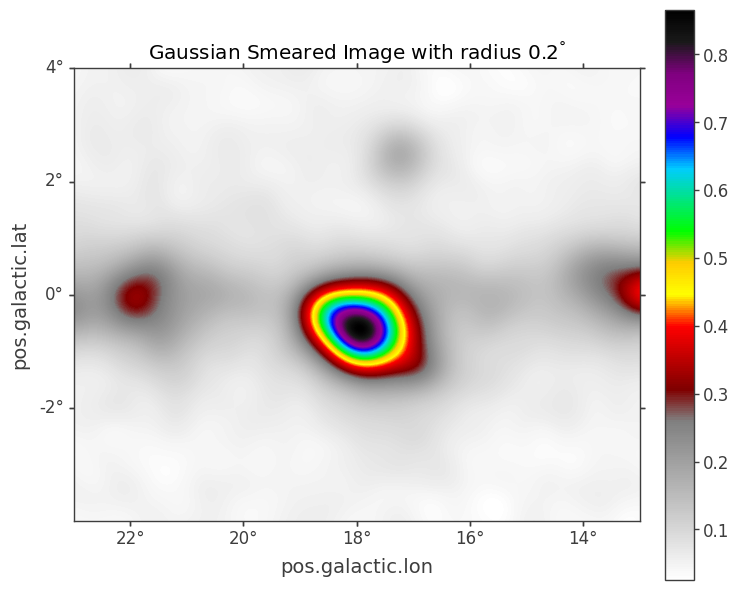

In [15]:
#Smearing Image with a gaussian for visualizing 
image = image
smear_radius = 0.2
gimage = gaussian(image, sigma=smear_radius/pixel_size)
print(np.min(gimage))
print(np.max(gimage))
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1, projection=wcs)

im=ax.imshow(gimage,  cmap=milagro)
fig.colorbar(im, orientation='vertical' ,fraction=0.046, pad=0.04)
ax.set_title(f"Gaussian Smeared Image with radius {smear_radius}$^\degree$")
ax.set_xlim(0, xnum)
ax.set_ylim(0, ynum)
plt.show()
plt.close(fig)

36.0


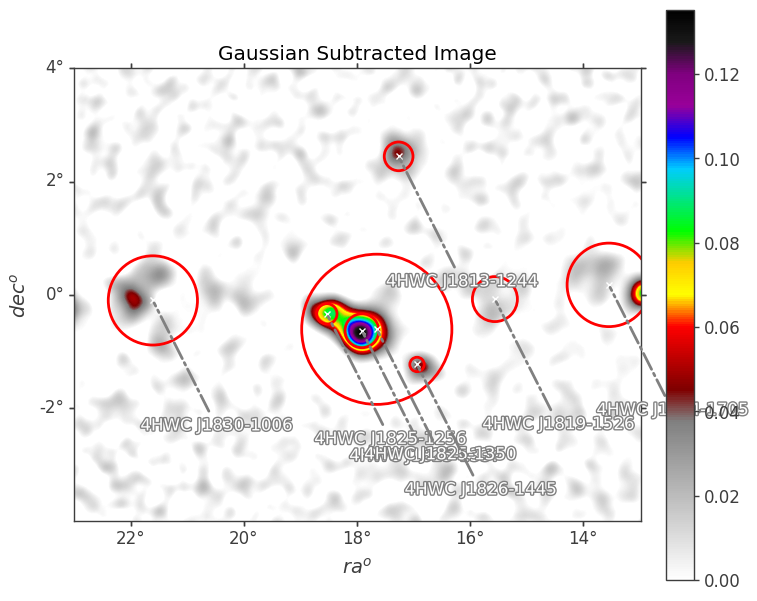

In [16]:
# Find the Difference of Gaussian (DoG) Image
psf=0.2 #PSF of the dec band
print(psf/pixel_size)
new_image = difference_of_gaussians(image, 1, psf/pixel_size)
fig = plt.figure(figsize=(8,8))
ax2 = plt.subplot(1,1,1, projection=wcs)
new_image = gaussian(new_image, sigma=3)
im2=ax2.imshow(new_image,  cmap=milagro, vmin=0)
fig.colorbar(im2, orientation='vertical',fraction=0.046, pad=0.04)
plot_ax_label(ax2, coord_sys='C')
ax2.set_title(f'Gaussian Subtracted Image')
plot_4hwc1D(ax2, wcs)
plt.xlim(0, xnum)
plt.ylim(0, ynum)
plt.show()

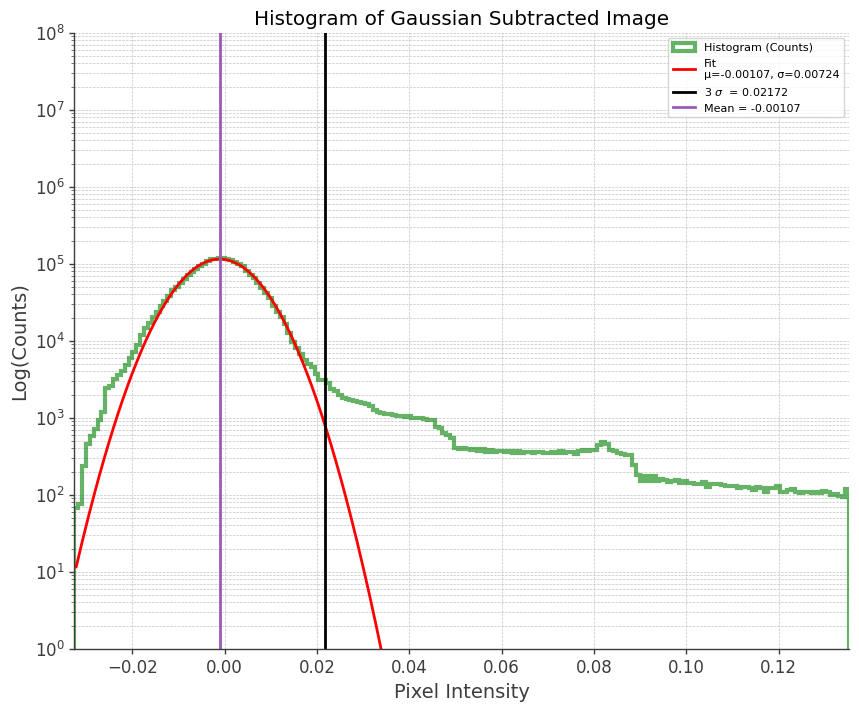

In [28]:
# Calculate the 1D histogram of the DoG Image
pixels = new_image.flatten()
sigma_resid2 = np.std(new_image)


counts, bin_edges = np.histogram(pixels, bins=200, range=(np.min(pixels), np.max(pixels)))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 

def gaussian_fit(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean)**2) / (2 * stddev**2))

x_exp = np.linspace(np.min(bin_edges), np.max(bin_edges), 200)
y_exp = gaussian_fit(x_exp, counts.max(), 0, 0.01)

initial_guess = [counts.max(), bin_centers[np.argmax(counts)], np.std(pixels)]
popt, _ = curve_fit(gaussian_fit, bin_centers, counts, p0=initial_guess)
x_fit = np.linspace(bin_centers[0], bin_centers[-1], 500)
y_fit = gaussian_fit(x_fit, *popt)

sigma_resid = popt[2]
deviation = 3*sigma_resid
plt.figure(figsize=(10, 8))

log_counts = np.where(counts > 0, counts, 1) 
plt.hist(pixels, bins=200, range=(np.min(pixels), np.max(pixels)),  color='fuchsia', edgecolor='green', alpha=0.6, label='Histogram (Counts)',histtype='step', linewidth=3)
# plt.plot(x_exp, y_exp, 'cyan', linewidth=2, label=f'Expectation\nμ=0, σ=0.01')
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label=f'Fit\nμ={popt[1]:.5f}, σ={popt[2]:.5f}')
plt.axvline(deviation, label=f'3 $\sigma$  = {3*popt[2]:.5f}', color='black')
plt.axvline(popt[1], label=f'Mean = {popt[1]:.5f}')
plt.yscale('log')
plt.ylim(1, 1e8)
plt.xlim(np.min(bin_edges), np.max(bin_edges))
plt.xlabel('Pixel Intensity')
plt.ylabel('Log(Counts)')
plt.title('Histogram of Gaussian Subtracted Image')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
plt.close(fig)

In [18]:
# Find the blobs from the DoG image
ps_blobs = blob_dog(new_image, min_sigma=0.1/pixel_size, max_sigma=psf/pixel_size, threshold=0.01, exclude_border=20)#, overlap=0.9)
print("Number of point source blobs=",len(ps_blobs))
ext_blobs = blob_dog(new_image,min_sigma=psf/pixel_size, max_sigma=0.5/pixel_size, threshold=0.01, exclude_border=20)#, overlap=0.9)
print("Number of ext source blobs=",len(ext_blobs))

Number of point source blobs= 7
Number of ext source blobs= 6


In [19]:
# DoG Image Intensity Filtering
intensity_min = deviation
intensity_min2 = deviation


print(intensity_min2)
ps_filtered_blobs, ps_filtered_coords, ps_filtered_radius = blob_filter_intensity(ps_blobs, new_image, intensity_min, wcs)
print("No of ps = ", len(ps_filtered_blobs))
ext_filtered_blobs, ext_filtered_coords, ext_filtered_radius = blob_filter_intensity(ext_blobs, new_image, intensity_min2, wcs)
print("No of ext = ", len(ext_filtered_blobs))

0.0217156789171931
Blob Intensity 0.1281122622334279, Coords (276.52288114631426 deg, -13.645730333916099 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 0.08099008067793802, Coords (276.47213827964026 deg, -12.941388498889072 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 0.041802634417338405, Coords (276.56264570774414 deg, -14.87174608660602 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 0.04565751074421734, Coords (277.8930950294013 deg, -9.794848668025718 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 0.04133672760152021, Coords (273.3073317640596 deg, -12.713218171046071 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 0.028209795775247543, Coords (277.26696169845496 deg, -9.967632240461713 deg), Radius 28.8, Pixel Radius 0.08
No of ps =  6
Blob Intensity 0.12491547982671836, Coords (276.5077096127601 deg, -13.637957558103334 deg), Radius 36.0, Pixel Radius 0.1
Blob Intensity 0.08066577858468, Coords (276.47341145543453 deg, -12.998572070160195 deg), Radius 

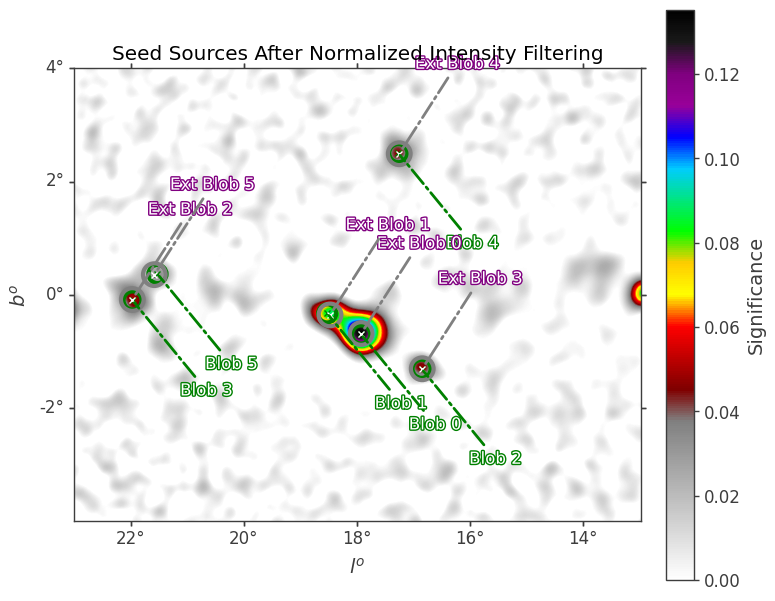

In [20]:
fig=plt.figure(figsize=(8, 8))
ax = plt.subplot(1,1,1, projection=wcs)
im=ax.imshow(new_image, cmap=milagro, vmin=0)
fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04, label='Significance')
ax.set_xlim(0, xnum)
ax.set_ylim(0, ynum)
ax.set_title("Seed Sources After Normalized Intensity Filtering")
plot_ax_label(ax, coord_sys)
plot_ps_blob(ax, ps_filtered_blobs, wcs)
plot_ext_blob(ax, ext_filtered_blobs, wcs)
plt.show()
plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Blob Intensity 90.45313097187311, Coords (276.52288114631426 deg, -13.645730333916099 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 62.35943257651076, Coords (276.47213827964026 deg, -12.941388498889072 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 26.871651208621365, Coords (276.56264570774414 deg, -14.87174608660602 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 30.929320084997926, Coords (277.8930950294013 deg, -9.794848668025718 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 16.643875671876227, Coords (273.3073317640596 deg, -12.713218171046071 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 22.98600730214289, Coords (277.26696169845496 deg, -9.967632240461713 deg), Radius 28.8, Pixel Radius 0.08
Blob Intensity 89.93501517338154, Coords (276.5077096127601 deg, -13.637957558103334 deg), Radius 36.0, Pixel Radius 0.1
Blob Intensity 65.39399656301761, Coords (276.47341145543453 deg, -12.998572070160195 deg), Radius 36.0, Pixel Radius 0.1
Blob Intensity 30.565

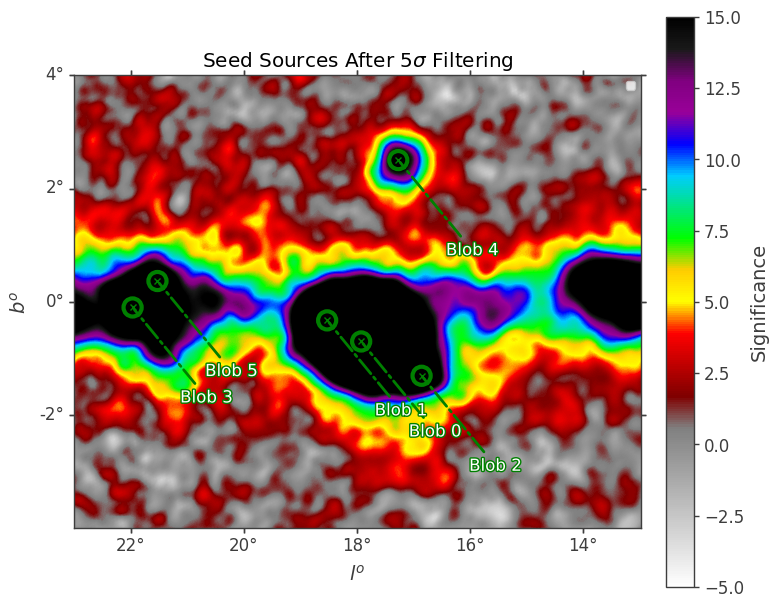

In [21]:
# Input Significance Image Intensity Filtering
ps_filtered_blobs2, ps_filtered_coords2, ps_filtered_radius2 = blob_filter_intensity(ps_filtered_blobs, array,5 , wcs)
ext_filtered_blobs3, ext_filtered_coords3, ext_filtered_radius3 = blob_filter_intensity(ext_filtered_blobs, array, 4, wcs)
print("No of ps = ", len(ps_filtered_blobs2))
print("No of ext = ", len(ext_filtered_blobs3))

fig=plt.figure(figsize=(8, 8))
ax = plt.subplot(1,1,1, projection=wcs)
im=ax.imshow(array, cmap=milagro, vmin=-5, vmax=15)
fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04, label='Significance')
ax.set_xlim(0, xnum)
ax.set_ylim(0, ynum)
ax.set_title(f"Seed Sources After 5$\sigma$ Filtering")
ax.legend(loc='upper right')
plot_ax_label(ax, coord_sys)
plot_ps_blob(ax, ps_filtered_blobs2, wcs)
plt.show()
plt.close(fig)

In [22]:
# Find the blobs from the Gaussian Smeared Image
ext_blobs2 = blob_dog(gimage,min_sigma=0.8/pixel_size, max_sigma=1.5/pixel_size, threshold=0.05, exclude_border=80)#, sigma_ratio=4)
print("Number of ext source blobs=",len(ext_blobs2))

Number of ext source blobs= 2


Blob Intensity 64.79243250046332, Coords (276.4108059029728 deg, -13.625967586655424 deg), Radius 144.0, Pixel Radius 0.4
Blob Intensity 22.296148732667632, Coords (277.8387585795384 deg, -9.873459113378106 deg), Radius 144.0, Pixel Radius 0.4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


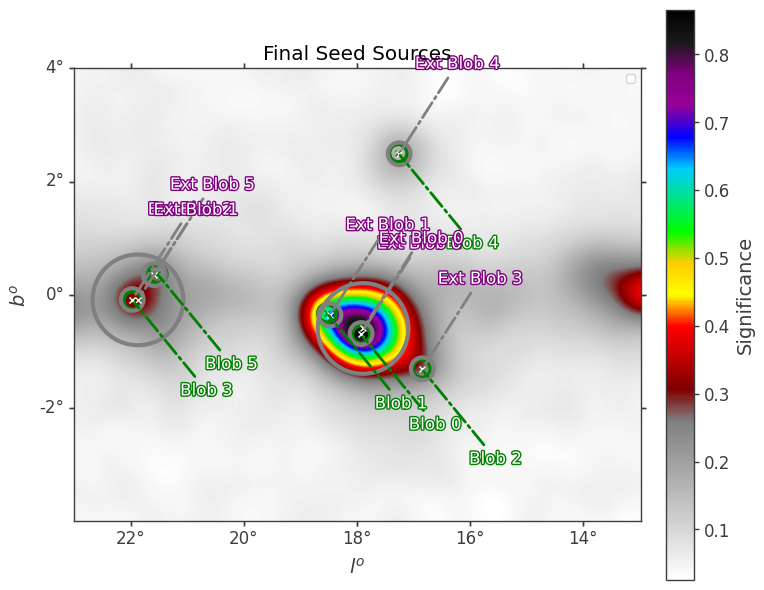

In [23]:
# Filter the Gaussian Blobs from above
ext_filtered_blobs2, ext_filtered_coords2, ext_filtered_radius2 = blob_filter_intensity(ext_blobs2, array, 4.5, wcs)
fig=plt.figure(figsize=(8, 8))
ax = plt.subplot(1,1,1, projection=wcs)
image=ax.imshow(gimage, cmap=milagro)#, vmin=-5, vmax=15)
fig.colorbar(image, orientation='vertical',fraction=0.046, pad=0.04, label='Significance')
ax.set_xlim(0, xnum)
ax.set_ylim(0, ynum)
ax.set_title("Final Seed Sources")
ax.legend(loc='upper right')
plot_ax_label(ax, coord_sys)
plot_ps_blob(ax, ps_filtered_blobs2, wcs)
plot_ext_blob(ax, ext_filtered_blobs3, wcs)
plot_ext_blob(ax, ext_filtered_blobs2, wcs)
# plot_ext_blob(ax, ext_blobs2, wcs)
# injected_sources_plot(inj_names, ra_vals , dec_vals, ext_vals, ax, wcs )
# pdf.savefig(fig, bbox_inches='tight')
plt.show()
plt.close(fig)

[<SkyCoord (ICRS): (ra, dec) in deg
    (276.52288115, -13.64573033)>, <SkyCoord (ICRS): (ra, dec) in deg
    (276.47213828, -12.9413885)>, <SkyCoord (ICRS): (ra, dec) in deg
    (276.56264571, -14.87174609)>, <SkyCoord (ICRS): (ra, dec) in deg
    (277.89309503, -9.79484867)>, <SkyCoord (ICRS): (ra, dec) in deg
    (273.30733176, -12.71321817)>, <SkyCoord (ICRS): (ra, dec) in deg
    (277.2669617, -9.96763224)>, <SkyCoord (ICRS): (ra, dec) in deg
    (276.4108059, -13.62596759)>, <SkyCoord (ICRS): (ra, dec) in deg
    (277.83875858, -9.87345911)>, <SkyCoord (ICRS): (ra, dec) in deg
    (276.50770961, -13.63795756)>, <SkyCoord (ICRS): (ra, dec) in deg
    (276.47341146, -12.99857207)>, <SkyCoord (ICRS): (ra, dec) in deg
    (277.88070857, -9.78221675)>, <SkyCoord (ICRS): (ra, dec) in deg
    (276.5572896, -14.88157701)>, <SkyCoord (ICRS): (ra, dec) in deg
    (273.30918227, -12.73316213)>, <SkyCoord (ICRS): (ra, dec) in deg
    (277.30313075, -9.92357496)>]
   Names          ra        

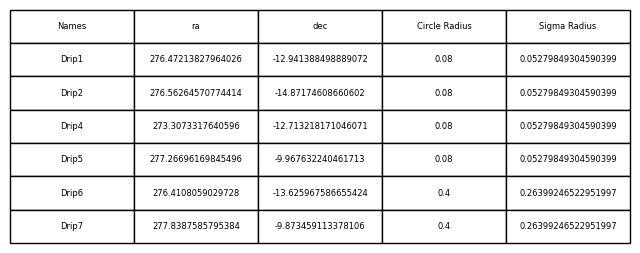

In [24]:
# Find sources that overlapping and less than 0.3 degrees and remove them
total_coords = ps_filtered_coords2 + ext_filtered_coords2 + ext_filtered_coords3
total_blobs = ps_filtered_blobs2 + ext_filtered_blobs2 + ext_filtered_blobs3
print(total_coords)
total_coords_ra = [ i.ra.value for i in ps_filtered_coords2] +[i.ra.value for i in ext_filtered_coords2] + [i.ra.value for i in ext_filtered_coords3]
total_coords_dec = [ i.dec.value for i in ps_filtered_coords2] +[i.dec.value for i in ext_filtered_coords2] + [i.dec.value for i in ext_filtered_coords3]
total_radius = ps_filtered_radius2 + ext_filtered_radius2 + ext_filtered_radius3
names = ['Drip'+str(i) for i in range(len(total_coords))]
df = pd.DataFrame(names, columns=['Names'])
df['ra'] = total_coords_ra
df['dec'] = total_coords_dec
df['Circle Radius'] = total_radius
def radius_to_sigma(R, fraction=0.6827):
    return R / np.sqrt(2 * np.log(1 / (1 - fraction)))

sigma_list = []
for R in total_radius:
    sigma = radius_to_sigma(R)
    sigma_list.append(sigma)

df['Sigma Radius'] = sigma_list

keep = np.ones(len(df), dtype=bool)

for i in range(len(df)):
    if not keep[i]:
        continue 
    for j in range(i + 1, len(df)):
        distance = np.sqrt((df.loc[i, 'ra'] - df.loc[j, 'ra'])**2 +
                           (df.loc[i, 'dec'] - df.loc[j, 'dec'])**2)
        radius1 = df.loc[i, 'Sigma Radius']
        radius2 = df.loc[j, 'Sigma Radius']
        if distance < 0.3:
            if radius1 > 0.1:
                keep[j] = False
            elif radius2 > 0.1:
                keep[i] = False
            elif radius1 < radius2:
                keep[j] = False

filtered_df = df[keep].reset_index(drop=True)
print(filtered_df)

fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off') 

try:
    table = ax.table(cellText=filtered_df.values,
                        colLabels=filtered_df.columns,
                        cellLoc='center',
                        loc='center')

    table.scale(1, 2)
except:
    text = f"DRIPS Compilation of Result for Crab Simulation Run {file}. No Source Found"
    ax.text(0.5, 0.5, text, fontsize=12, ha='center', va='center', wrap=True)
plt.show()
plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


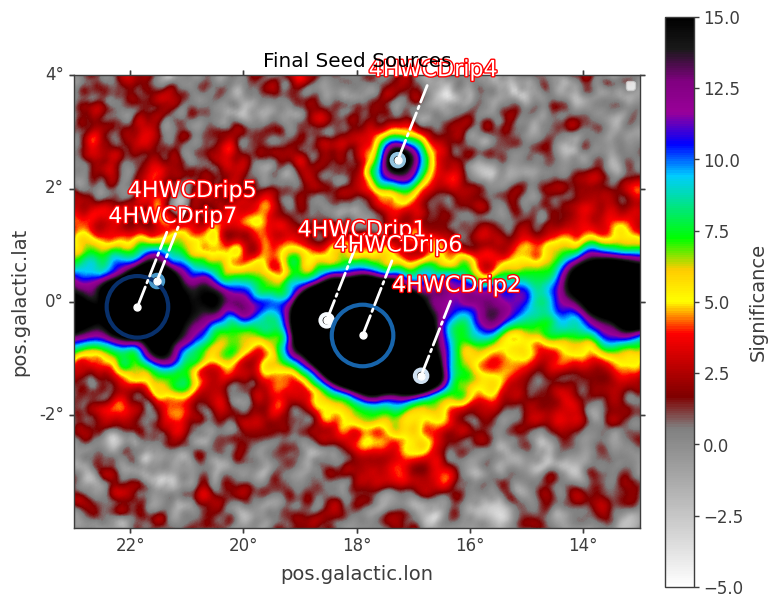

In [25]:
# Plot the Final Seeds
fig=plt.figure(figsize=(8, 8))
ax = plt.subplot(1,1,1, projection=wcs)
im=ax.imshow(array, cmap=milagro, vmin=-5, vmax=15)
fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04, label='Significance')
ax.set_xlim(0, xnum)
ax.set_ylim(0, ynum)
ax.set_title("Final Seed Sources")
ax.legend(loc='upper right')
color = cm.Blues(np.linspace(0, 1, len(filtered_df)))
custom_sources_plot(filtered_df['Names'], filtered_df['ra'], filtered_df['dec'], filtered_df['Sigma Radius'], ax, wcs, color)
plt.show()
plt.close(fig)

In [29]:
ra_m = []
dec_m = []
for xra, xdec in zip(filtered_df['ra'], filtered_df['dec']):
    ra_m.append(xra)
    dec_m.append(xdec)
source_name = {}
sources = {}
spectra = {}
morphologies = {}

for i in range(len(filtered_df)):
    if filtered_df['Sigma Radius'][i]<0.12:
        sources[f"spectrum{i}"] = Powerlaw()
        sources[f"source{i}"] = PointSource(f"Source{i}", ra=filtered_df['ra'][i], dec=filtered_df['dec'][i], spectral_shape=  sources[f"spectrum{i}"])
        fluxUnit = 1./(u.keV * u.cm ** 2 * u.s)

        # sources[f"spectrum{i}"].K = 1e-14
        sources[f"spectrum{i}"].K = 1e-24 * fluxUnit
        sources[f"spectrum{i}"].K.fix = False
        sources[f"spectrum{i}"].K.bounds = (1e-26, 1e-20) * fluxUnit
        sources[f"spectrum{i}"].index = -2.5 
        sources[f"spectrum{i}"].index.fix = False
        sources[f"spectrum{i}"].index.bounds = (-3, -1)
        sources[f"spectrum{i}"].piv = 10 * u.TeV
        sources[f"spectrum{i}"].piv.fix = True

        sources[f"source{i}"].position.ra.free = True
        sources[f"source{i}"].position.ra.bounds = ((ra_m[i] - 1), (ra_m[i]+1)) * u.degree
        sources[f"source{i}"].position.dec.free = True
        sources[f"source{i}"].position.dec.bounds = ((dec_m[i] - 1), (dec_m[i]+1)) * u.degree
    else:
        sources[f"spectrum{i}"] = Powerlaw()
        shape = Gaussian_on_sphere()
        sources[f"source{i}"] = ExtendedSource(f"Source{i}", spatial_shape=shape, spectral_shape=sources[f"spectrum{i}"])
        fluxUnit = 1./(u.keV * u.cm ** 2 * u.s)

        # sources[f"spectrum{i}"].K = 1e-14
        sources[f"spectrum{i}"].K = 1e-24 * fluxUnit
        sources[f"spectrum{i}"].K.fix = False
        sources[f"spectrum{i}"].K.bounds = (1e-26, 1e-20) * fluxUnit
        sources[f"spectrum{i}"].index = -2.5 
        sources[f"spectrum{i}"].index.fix = False
        sources[f"spectrum{i}"].index.bounds = (-3, -1)
        sources[f"spectrum{i}"].piv = 10 * u.TeV
        sources[f"spectrum{i}"].piv.fix = True

        sources[f"source{i}"].lon0 = filtered_df['ra'][i] * u.degree
        sources[f"source{i}"].lon0.fix = False
        sources[f"source{i}"].lon0.bounds = ((filtered_df['dec'][i] - 1), (filtered_df['dec'][i]+1)) * u.degree
        sources[f"source{i}"].lat0 = filtered_df['ra'][i] * u.degree
        sources[f"source{i}"].lat0.fix = False
        sources[f"source{i}"].lat0.bounds = ((filtered_df['dec'][i] - 1), (filtered_df['dec'][i]+1)) * u.degree

        sources[f"source{i}"].sigma = filtered_df['Sigma Radius'][i] * u.degree
        sources[f"source{i}"].lon0.fix = False
        sources[f"source{i}"].lon0.bounds = (0.01, 2)

keys_to_remove = [key for key in sources if key.startswith("spectrum")]

# Remove those keys from the dictionary
for key in keys_to_remove:
    del sources[key]
allmodel = Model(*sources.values())

16:47:59 WARNING   We have set the min_value of Source0.spectrum.main.Powerlaw.K to 1e-99 because  ]8;id=288159;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=337343;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         WARNING   We have set the min_value of Source1.spectrum.main.Powerlaw.K to 1e-99 because  ]8;id=541553;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=623169;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         WARNING   We have set the min_value of Source2.spectrum.main.Powerlaw.K to 1e-99 because  ]8;id=814397;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=805319;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         WARNING   We have set the min_value of Source3.spectrum.main.Powerlaw.K to 1e-99 because  ]8;id=382389;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=554143;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         WARNING   We have set the min_value of Source4.spectrum.main.Powerlaw.K to 1e-99 because  ]8;id=514400;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=173922;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         WARNING   We have set the min_value of Source5.spectrum.main.Powerlaw.K to 1e-99 because  ]8;id=498757;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=61824;file:///Users/rishi/Documents/Analysis/miniconda3/envs/astro_hal/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

In [31]:
print(len(allmodel.sources), len(filtered_df))
print(allmodel)
allmodel.save("modelFit.yml", overwrite=True)

6 6
Model summary:

                  N
Point sources     4
Extended sources  2
Particle sources  0

Free parameters (26):
--------------------

                                           value   min_value   max_value  \
Source0.position.ra                   276.472138  275.472138  277.472138   
Source0.position.dec                  -12.941388  -13.941388  -11.941388   
Source0.spectrum.main.Powerlaw.K             0.0         0.0         0.0   
Source0.spectrum.main.Powerlaw.index        -2.5        -3.0        -1.0   
Source1.position.ra                   276.562646  275.562646  277.562646   
Source1.position.dec                  -14.871746  -15.871746  -13.871746   
Source1.spectrum.main.Powerlaw.K             0.0         0.0         0.0   
Source1.spectrum.main.Powerlaw.index        -2.5        -3.0        -1.0   
Source2.position.ra                   273.307332  272.307332  274.307332   
Source2.position.dec                  -12.713218  -13.713218  -11.713218   
Source2.spectrum.ma